# dividends vs no-dividends

Compare SPY with and without dividends.

In [12]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd

import pinkfish as pf

# Format price data.
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [13]:
# Set size of inline plots.
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

In [14]:
symbol = 'SPY'
capital = 10000
start = datetime.datetime(1900, 1, 1)                   
end = datetime.datetime.now()

Timeseries

In [15]:
# Fetch timeseries, select, finalize.
ts = pf.fetch_timeseries(symbol)
ts = pf.select_tradeperiod(ts, start, end, use_adj=True)
ts, start = pf.finalize_timeseries(ts, start)

# Create tradelog and daily balance objects.
tlog = pf.TradeLog(symbol)
dbal = pf.DailyBal()

In [16]:
ts

,open,high,low,close,adj_close,volume
date,,,,,,
1993-01-29,25.24,25.24,25.11,25.22,25.22,1003200
1993-02-01,25.24,25.40,25.24,25.40,25.40,480500
1993-02-02,25.38,25.47,25.33,25.45,25.45,201300
1993-02-03,25.49,25.74,25.47,25.72,25.72,529400
1993-02-04,25.81,25.88,25.52,25.83,25.83,531500
...,...,...,...,...,...,...
2022-12-22,383.05,386.21,374.77,380.72,380.72,100120900
2022-12-23,379.65,383.06,378.03,382.91,382.91,59761100
2022-12-27,382.79,383.15,379.65,381.40,381.40,51638200


Algorithm

In [17]:
pf.TradeLog.cash = capital

# Loop through timeseries.
for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    end_flag = pf.is_last_row(ts, i)

    # Buy.
    if tlog.shares == 0:
        tlog.buy(date, row.close)
    # Sell.
    elif end_flag:
        tlog.sell(date, row.close)

    # Record daily balance.
    dbal.append(date, row.close)

Retrieve logs and get stats

In [18]:
tlog = tlog.get_log()
dbal = dbal.get_log(tlog)
stats = pf.stats(ts, tlog, dbal, capital)

Benchmark: Run, retrieve logs, generate stats

In [19]:
benchmark = pf.Benchmark(symbol, capital, start, end, use_adj=False)
benchmark.run()

Plot Equity Curves: Dividends (strategy) vs No-Dividends (benchmark)

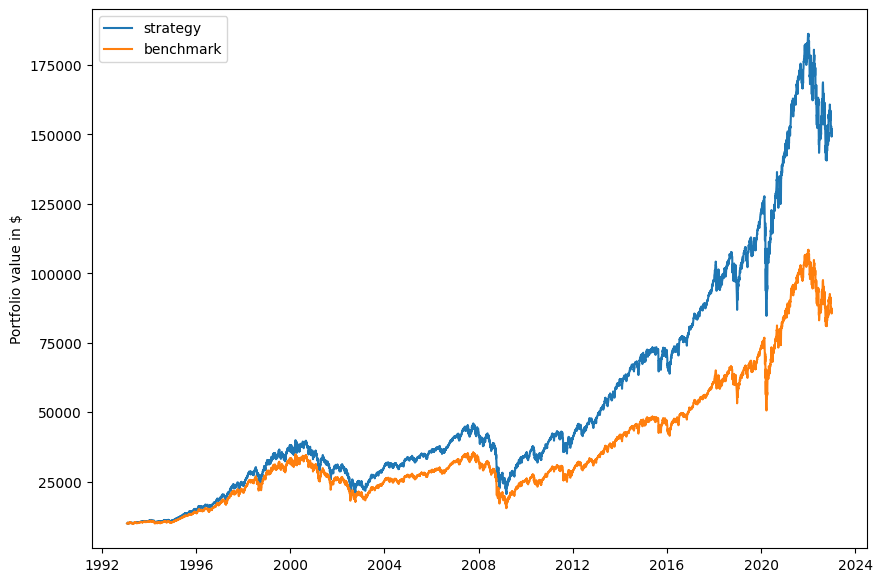

In [20]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal, fname='equity_curve.png')

Dividends (strategy) vs No-Dividends (benchmark)

In [21]:
pf.summary(stats, benchmark.stats, metrics=pf.currency_metrics)

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$151,855.82","$87,067.07"
total_net_profit,"$141,855.82","$77,067.07"
gross_profit,"$141,855.82","$77,067.07"
gross_loss,$0.00,$0.00


,strategy,benchmark
annual_return_rate,9.52,7.50
max_closed_out_drawdown,-55.17,-56.43
annualized_return_over_max_drawdown,0.17,0.13
best_month,23.61,23.06
worst_month,-30.98,-31.38
sharpe_ratio,0.58,0.48
sortino_ratio,0.73,0.61
monthly_std,4.50,4.50
annual_std,17.14,16.80
avg_month,0.83,0.68


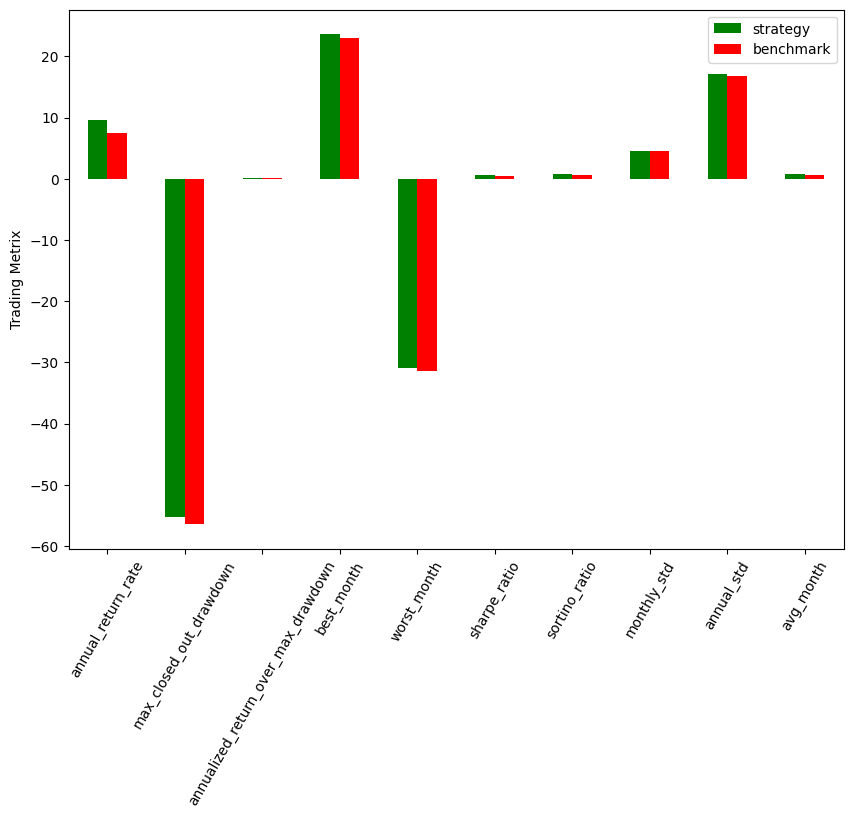

In [22]:
pf.plot_bar_graph(stats, benchmark.stats, extras=('avg_month',))